In [1]:
%matplotlib notebook

# Dataset maps

This notebook demonstrates the usage of "data maps" as shown in the paper [Dataset Cartography: Mapping and Diagnosing Datasets with Training Dynamics](https://arxiv.org/pdf/2009.10795) on the QNLI dataset, using the DistilBERT model.

To run this notebook, make sure you have installed the following libraries:
 - `tensorflow`
 - `tensorflow-datasets`
 - `transformers`
 - `tavolo`
 - `matplotlib`
 - `transformers`


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tavolo as tvl
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, glue_convert_examples_to_features

In [3]:
# Set plot style
sns.set_style('whitegrid')
sns.set_palette('Set2')

## Load Datasets

In [4]:
# Load datasets
train, info = tfds.load('glue/qnli', split='train', shuffle_files=True, with_info=True)
train_unshuffled = tfds.load('glue/qnli', split='train', shuffle_files=False)
validation = tfds.load('glue/qnli', split='validation', shuffle_files=True)
test = tfds.load('glue/qnli', split='test', shuffle_files=True)

# Prepare datasets for Huggingface's transformers
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

train = glue_convert_examples_to_features(train, tokenizer, max_length=128, task='qnli')
train_unshuffled = glue_convert_examples_to_features(train_unshuffled, tokenizer, max_length=128, task='qnli')
validation = glue_convert_examples_to_features(validation, tokenizer, max_length=128, task='qnli')
test = glue_convert_examples_to_features(test, tokenizer, max_length=128, task='qnli')

validation = validation.batch(128).prefetch(1)
train = train.shuffle(1000).repeat().batch(64).prefetch(1)

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: glue/qnli/1.0.0
INFO:absl:Load dataset info from /tmp/tmp00ar2f2qtfds
INFO:absl:Field info.description from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.location from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset glue (/root/tensorflow_datasets/glue/qnli/1.0.0)


INFO:absl:Downloading https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQNLIv2.zip?alt=media&token=6fdcf570-0fc5-4631-8456-9505272d1601 into /root/tensorflow_datasets/downloads/fire.goog.com_v0_b_mtl-sent-repr.apps.GxR0vHD73kd0dlbqXVFqnKhivczD12iHXZrYJDZ6MJo.zipalt=media&token=6fdcf570-0fc5-4631-8456-9505272d1601.tmp.e4e015228d63456eb39869664cec8f03...
INFO:absl:Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/glue/qnli/1.0.0.incompleteVN40HI/glue-train.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/glue/qnli/1.0.0.incompleteVN40HI/glue-train.tfrecord. Shard lengths: [104743]
INFO:absl:Generating split validation


Shuffling and writing examples to /root/tensorflow_datasets/glue/qnli/1.0.0.incompleteVN40HI/glue-validation.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/glue/qnli/1.0.0.incompleteVN40HI/glue-validation.tfrecord. Shard lengths: [5463]
INFO:absl:Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/glue/qnli/1.0.0.incompleteVN40HI/glue-test.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/glue/qnli/1.0.0.incompleteVN40HI/glue-test.tfrecord. Shard lengths: [5463]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.AUTO.
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/glue/qnli/1.0.0


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/qnli/1.0.0. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/glue/qnli/1.0.0
INFO:absl:Reusing dataset glue (/root/tensorflow_datasets/glue/qnli/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split train, from /root/tensorflow_datasets/glue/qnli/1.0.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/glue/qnli/1.0.0
INFO:absl:Reusing dataset glue (/root/tensorflow_datasets/glue/qnli/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split validation, from /root/tensorflow_datasets/glue/qnli/1.0.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/glue/qnli/1.0.0
INFO:absl:Reusing dataset glue (/root/tensorflow_datasets/glue/qnli/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split test, from /root/tensorflow_datasets/glue/qnli/1.0.0


## Dataset info

In [5]:
print(info)

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.',
    homepage='https://rajpurkar.github.io/SQuAD-explorer/',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'question': Text(shape=(), dtype=tf.string),
        'sentence': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=115669,
    splits={
        'test': 5463,
        'train': 104743,
        'validation': 5463,
    },
    supervised_keys=None,
    citation="""@article{rajpurkar2016squad,
      title={Squad: 100,000+ questions for machine comprehension of text},
      author={Rajpurkar, Pranav and Zhang, Jian and Lopyrev, Konstantin and Liang, Percy},
      journal={arXiv preprint arXiv:1606.05250},
      year={2

_Notice_: When the label is 0, it means the sentence (answer) does match the question. **0 = right, 1 = wrong.**

## Load model

In [6]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it fo

## Train model

In [7]:
# Compile model
dataset_map = tvl.learning.DataMapCallback(train_unshuffled.batch(128), 
                                           outputs_to_probabilities=lambda x: tf.nn.softmax(x[0]), # Model outputs a tuple, where the logits are at the first index
                                           sparse_labels=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
callbacks = [dataset_map, tf.keras.callbacks.EarlyStopping(patience=3)]

model.compile(optimizer=optimizer, loss=loss)

In [8]:
# Fit
model.fit(train, epochs=100, validation_data=validation, steps_per_epoch=150, callbacks=callbacks)

Epoch 1/100
150/150 [==============================] - 528s 4s/step - loss: 0.5774 - val_loss: 0.4331
Epoch 2/100
150/150 [==============================] - 528s 4s/step - loss: 0.4693 - val_loss: 0.4019
Epoch 3/100
150/150 [==============================] - 535s 4s/step - loss: 0.4413 - val_loss: 0.3921
Epoch 4/100
150/150 [==============================] - 530s 4s/step - loss: 0.4266 - val_loss: 0.3764
Epoch 5/100
150/150 [==============================] - 501s 3s/step - loss: 0.4063 - val_loss: 0.3508
Epoch 6/100
150/150 [==============================] - 498s 3s/step - loss: 0.4002 - val_loss: 0.3816
Epoch 7/100
150/150 [==============================] - 497s 3s/step - loss: 0.3866 - val_loss: 0.3436
Epoch 8/100
150/150 [==============================] - 498s 3s/step - loss: 0.3838 - val_loss: 0.3307
Epoch 9/100
150/150 [==============================] - 524s 3s/step - loss: 0.3605 - val_loss: 0.3279
Epoch 10/100
150/150 [==============================] - 501s 3s/step - loss: 0.353

## Plot Data Map

By now we have in the `dataset_map` all the information we need to plot the data map for the QNLI training set, for the DistilBERT model

### Scatter plot

<IPython.core.display.Javascript object>


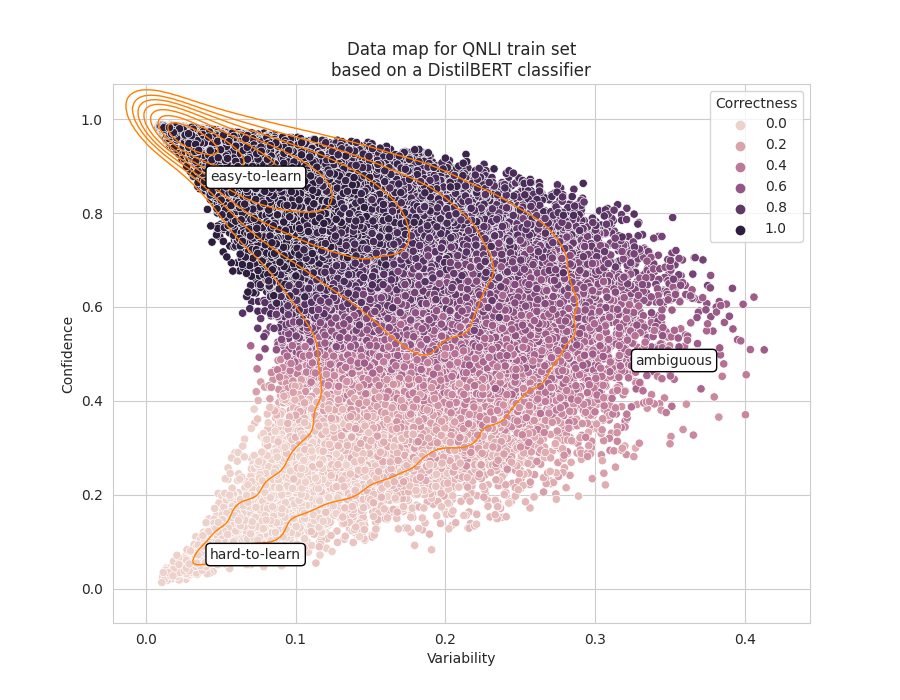

In [28]:
# Plot
_, ax = plt.subplots(figsize=(9, 7))


sns.scatterplot(x=dataset_map.variability, y=dataset_map.confidence, hue=dataset_map.correctness, ax=ax)
sns.kdeplot(x=dataset_map.variability, y=dataset_map.confidence, 
            levels=8, color=sns.color_palette("Paired")[7], linewidths=1, ax=ax)

ax.set(title='Data map for QNLI train set\nbased on a DistilBERT classifier',
       xlabel='Variability', ylabel='Confidence')

# Annotations
box_style = {'boxstyle': 'round', 'facecolor': 'white', 'ec': 'black'}
ax.text(0.14, 0.84,
        'easy-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.75, 0.5,
        'ambiguous',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.14, 0.14,
        'hard-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)

ax.legend(title='Correctness');